### Comparison of the coherence metric between the original and surrogate data

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')

import time
import scipy
import h5py
import numpy                 as     np
import xarray                as     xr
import pandas                as     pd
import matplotlib.pyplot     as     plt
import seaborn               as     sns
from   tqdm                  import tqdm
from   xfrites.conn.conn_coh import conn_coherence_wav

from GDa.session             import session_info, session
from GDa.signal.surrogates   import trial_swap_surrogates, phase_rand_surrogates

#### Setting the parameters

In [2]:
_RANDOMIZE = 'phases'

#### Loading data - for correct task trials

In [3]:
# Instantiate class
s = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,
            slvr_msmod = False, align_to = 'cue', evt_dt = [-0.65, 3.00])
# Read data from .mat files
s.read_from_mat()

In [4]:
idx  = s.trial_info[(s.trial_info['trial_type']==1.0) \
                    & (s.trial_info['behavioral_response']==1.0)].trial_index.values

In [5]:
data = s.data.sel(trials=idx)#.isel(roi=[47,48])

#### Generate trial randomization surrogates

In [6]:
seeds     = np.arange(0, 10, dtype=int) * 100

if _RANDOMIZE == 'trials':
    # Randomized trials data
    data_surr = []
    for seed in tqdm( seeds ):
        data_rt += [trial_swap_surrogates(data,seed=seed,verbose=False)];
    data_surr = xr.concat(data_surr, dim="seeds")

#### Generate randomized phase surrogates

In [7]:
if _RANDOMIZE == 'phases':
    # Randomize data phases
    data_surr = []
    for seed in tqdm( seeds ):
        data_surr += [phase_rand_surrogates(data,val=0,seed=seed,verbose=False,n_jobs=-1)];
    data_surr = xr.concat(data_surr, dim="seeds")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 10%|█         | 1/10 [00:08<01:13,  8.18s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 20%|██        | 2/10 [00:12<00:45,  5.67s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 30%|███       | 3/10 [00:16<00:35,  5.03s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 40%|████      | 4/10 [00:19<00:26,  4.44s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 50%|█████     | 5/10 [00:23<00:21,  4.25s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 60%|██████    | 6/10 [00:27<00:16,  4.02s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 70%|███████   | 7/10 [00:31<00:12,  4.02s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 80%|████████  | 8/10 [00:35<00:07,  3.98s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 90%|█████████ | 9/10 [00:39<00:03,  3.99s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

100%|██████████| 10/10 [00:43<00:00,  4.35s/it]


#### Computing coherence

In [8]:
sm_times = 300
sm_freqs = 1
# Downsampling factor
delta = 15       
mode  = 'morlet'
foi   = np.array([
        [0.1, 6.],
        [6., 14.],
        [14., 26.],
        [26., 42.],
        [42., 80.]
            ])
n_freqs   = 50
freqs     = np.linspace(foi[0,0], foi[-1,1], n_freqs, endpoint=True)
n_cycles  = freqs/2
decim_at  ='tfd'

x_s, x_t  = np.triu_indices(data.sizes['roi'], k=1)
pairs     = np.array([x_s,x_t]).T

In [9]:
kw = dict(
    freqs=freqs, times=data.time, roi=data.roi, foi=foi, n_jobs=20,
    sfreq=data.attrs['fsample'], mode=mode, n_cycles=n_cycles, decim=delta,
    sm_times=sm_times, sm_freqs=1, block_size=1, decim_at=decim_at, verbose=False
)

In [ ]:
coh      = conn_coherence_wav(data, **kw).astype(np.float32);

Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   18.9s remaining:    4.3s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   21.8s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

In [20]:
coh_surr = []
for i in tqdm( range(len(seeds)) ):
    coh_surr += [conn_coherence_wav(data_surr.isel(seeds=i), **kw).astype(np.float32)];
coh_surr = xr.concat(coh_surr, dim="seeds")

  0%|          | 0/10 [00:00<?, ?it/s]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   24.3s remaining:    5.5s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   27.3s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 10%|█         | 1/10 [03:00<27:06, 180.75s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   23.9s remaining:    5.4s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   26.8s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 20%|██        | 2/10 [06:00<24:03, 180.41s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   23.5s remaining:    5.3s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   26.4s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 30%|███       | 3/10 [09:00<21:00, 180.01s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   23.4s remaining:    5.3s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   26.3s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 40%|████      | 4/10 [12:00<18:00, 180.09s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   24.0s remaining:    5.4s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   26.8s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 50%|█████     | 5/10 [15:00<15:00, 180.07s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   23.7s remaining:    5.3s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   26.6s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 60%|██████    | 6/10 [18:01<12:01, 180.46s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   24.2s remaining:    5.4s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   27.1s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 70%|███████   | 7/10 [21:04<09:02, 181.00s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   23.9s remaining:    5.4s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   26.8s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 80%|████████  | 8/10 [24:05<06:02, 181.20s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   24.3s remaining:    5.5s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   27.2s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 90%|█████████ | 9/10 [27:08<03:01, 181.62s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   24.3s remaining:    5.5s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   27.2s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

100%|██████████| 10/10 [30:08<00:00, 180.87s/it]


In [23]:
#del coh.attrs['mt_bandwidth']
#coh.to_netcdf('data/coh_orig_rt.nc')
#del coh_surr.attrs['mt_bandwidth']
#coh_surr.to_netcdf('data/coh_surr_rt.nc')

In [14]:
# Saving distributions for trial shuffling surrogates
bins = np.linspace(0,1,100)
for r in tqdm( range(coh.sizes['roi']) ):
    plt.figure(figsize=(8,15))
    count = 1
    for i in range(5):
        plt.subplot(5,1,count)
        plt.suptitle(f'link={coh.roi.values[r]}', fontsize=15)
        for j in range(10):
            #coh_surr = xr.load_dataarray(f'data/coh_surr_rt_{j}.nc')
            if j==0:
                plt.hist( coh_surr.isel(seeds=j,freqs=i,roi=r).values.flatten(), bins=bins, density=True, histtype='step', fill=False, color='r', label='Surrogate');
            else:
                plt.hist( coh_surr.isel(seeds=j,freqs=i,roi=r).values.flatten(), bins=bins, density=True, histtype='step', fill=False, color='r');
        plt.hist( coh.isel(freqs=i, roi=r).values.flatten(), bins=bins,  density=True, histtype='step', fill=False, color='k', label='Original', lw=5);
        plt.title(f'band {i}', fontsize=15)
        plt.ylabel('#', fontsize=15) 
        plt.legend()
        count += 1
    plt.tight_layout()
    plt.xlabel(f'Coherence', fontsize=15)
    plt.savefig(f'img/surr_dist_roi{r}.png')
    plt.close()

100%|██████████| 1176/1176 [10:04<00:00,  1.94it/s]


#### KS-test

In [21]:
from scipy.stats import ks_2samp

In [22]:
#### Loading data
#coh      = xr.load_dataarray('data/coh_orig.nc')
#coh_surr = xr.load_dataarray('data/coh_surr.nc')
#to_netcdf('data/coh_orig.nc')

In [23]:
def ks_test(data, data_surr, verbose=False, n_jobs=1):
    from frites.utils import parallel_func
    
    def _for_band(band):
        ks = np.zeros(data.shape[1])
        for i in range( data.shape[1] ):
            ks[i] = ks_2samp(data[:,i,band,:].flatten(),data_surr[:,:,i,band,:].flatten(), alternative='two-sided')[1]
        return ks
    # define the function to compute in parallel
    parallel, p_fun = parallel_func( _for_band, n_jobs=n_jobs, 
                                     verbose=verbose, total=data.shape[2]
                                   )
    ks = parallel(p_fun(band) for band in range(data.shape[2]))
    return ks

In [27]:
ks_stats   = np.zeros((coh.sizes['roi'],coh.sizes['freqs']))
ks         = ks_test(coh.values,coh_surr.values,True,-1)

  0%|          |  : 0/5 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.7min finished


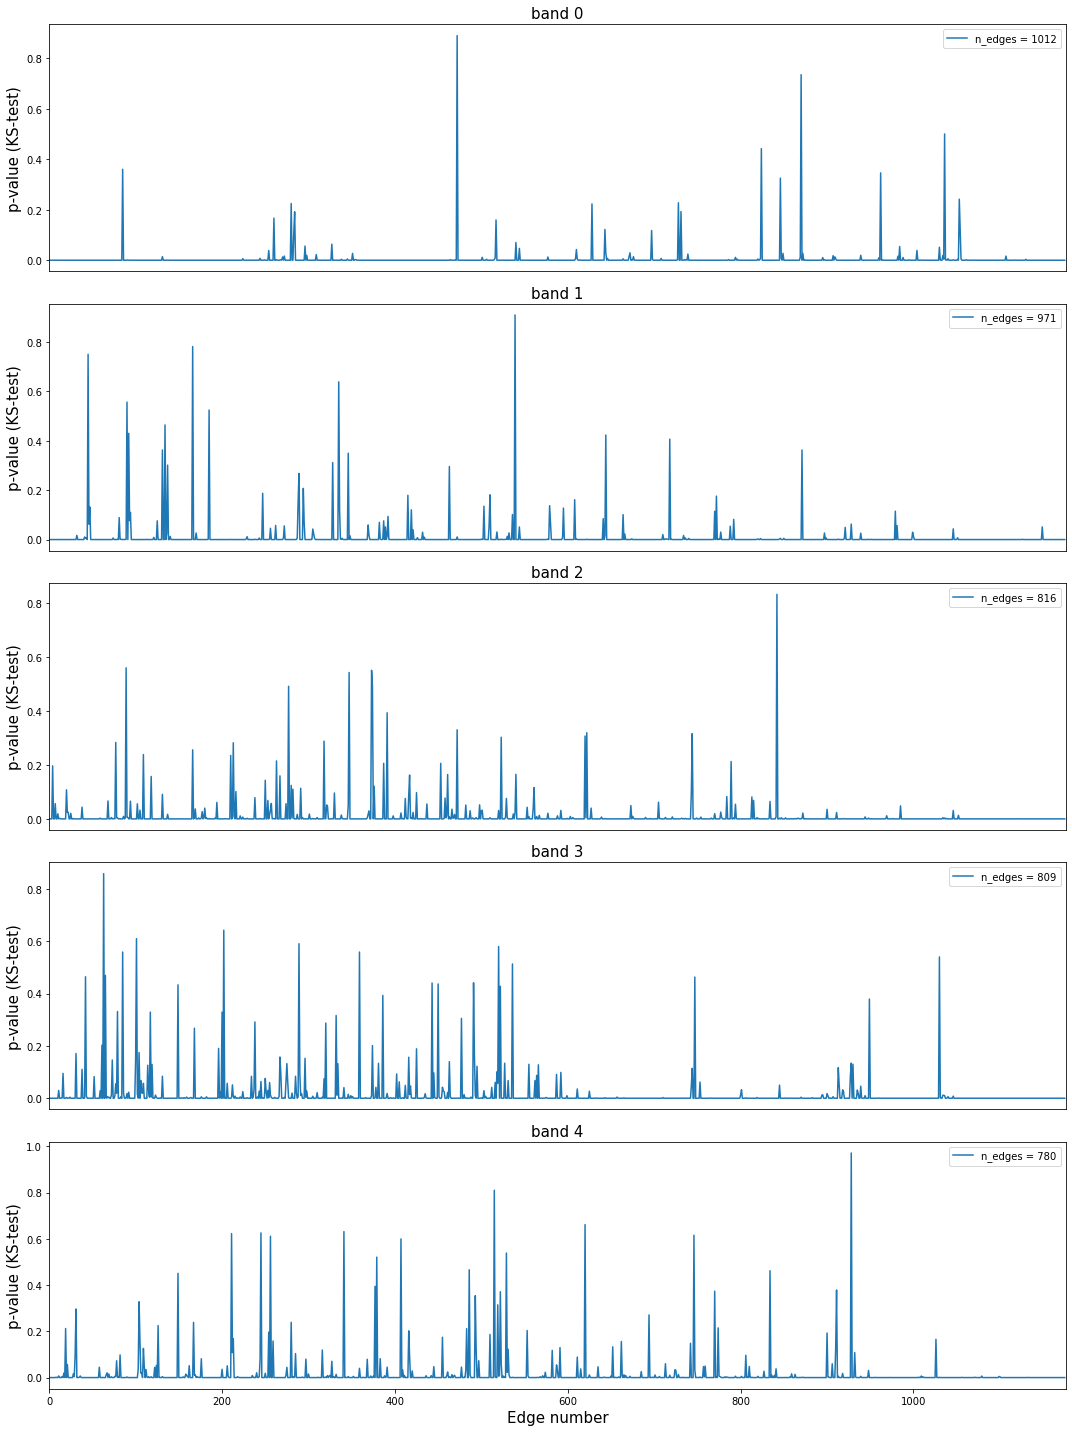

In [29]:
plt.figure(figsize=(15,20))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.plot(ks[i], label=f'n_edges = {np.sum(ks[i]<1e-5)}')
    plt.ylabel('p-value (KS-test)', fontsize=15)
    if i == 4: plt.xlabel('Edge number', fontsize=15)
    else: plt.xticks([])
    plt.title(f'band {i}', fontsize=15)
    plt.xlim([0,ks[i].shape[0]])
    plt.legend()
plt.tight_layout()
plt.savefig('img/ks_test.png', dpi=200)

In [30]:
ks_mat = np.zeros((5,data.sizes['roi'],data.sizes['roi']))
for i in range(5):
    idx         = ks[i] <1e-5
    x_s_i,x_t_i = x_s[idx], x_t[idx]
    ks_mat[i,x_s_i,x_t_i] = ks_mat[i,x_t_i,x_s_i] = 1

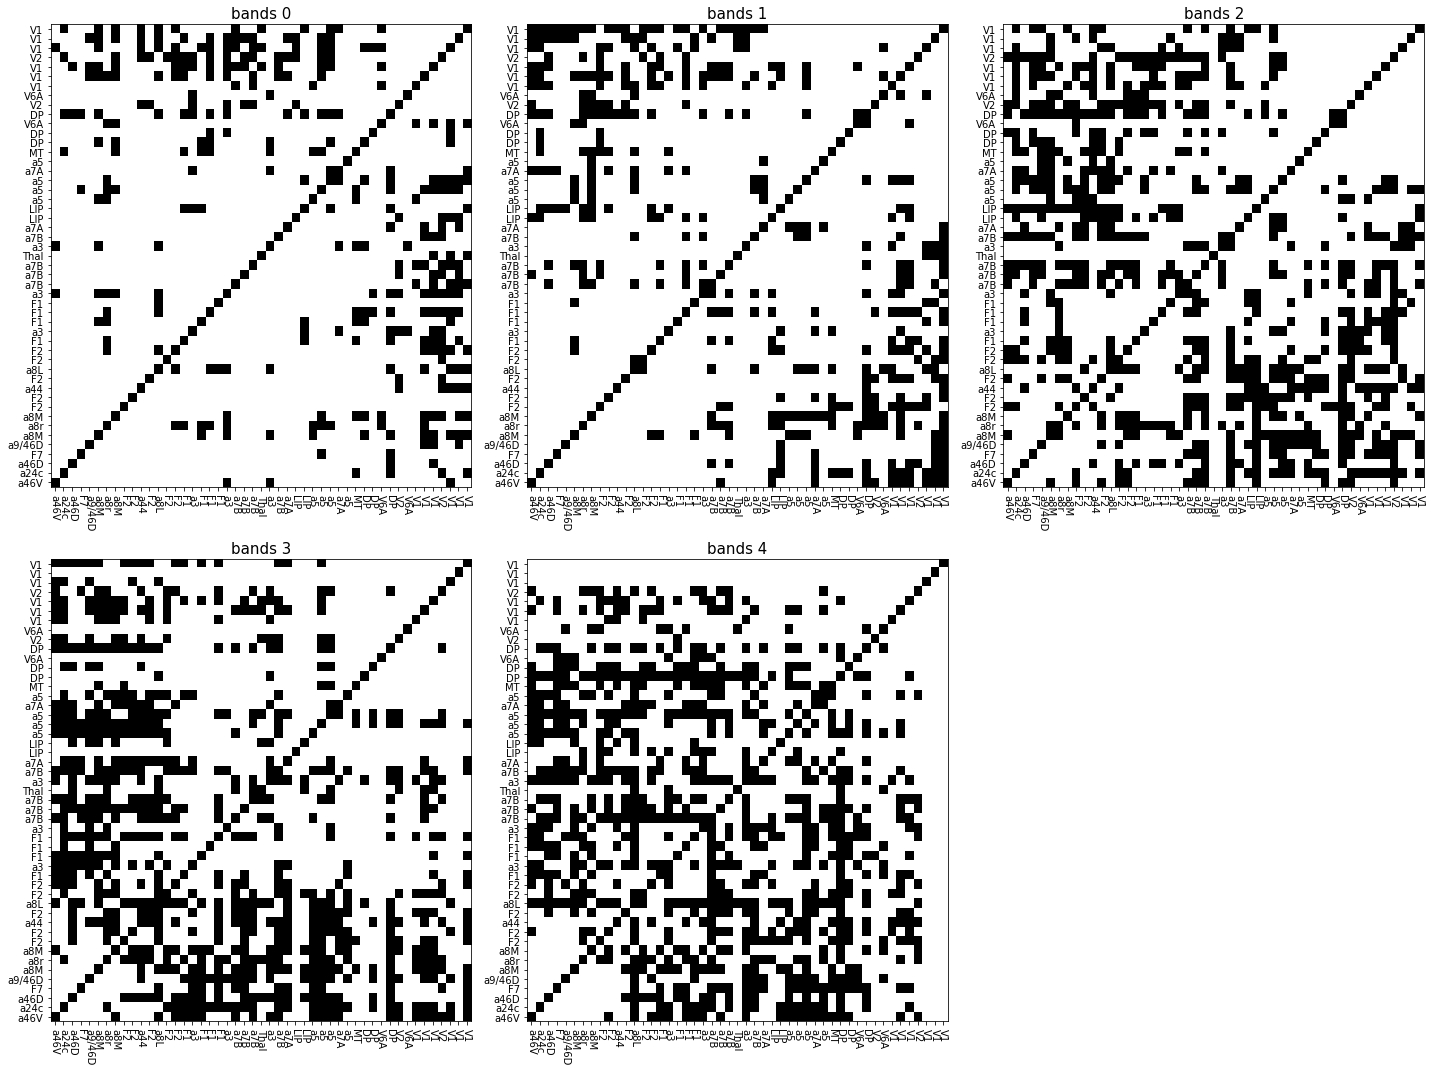

In [31]:
plt.figure(figsize=(20,15))
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.imshow(ks_mat[i], aspect='auto', origin = 'lower', cmap='gray')
    plt.xticks(range(data.sizes['roi']), data.roi.values, rotation=270)
    plt.yticks(range(data.sizes['roi']), data.roi.values)
    plt.title(f'bands {i}', fontsize=15)
plt.tight_layout()

#### Checking a few histograms with p<1e-5

In [75]:
# Edges with signigicative coherence for all bands
idx = (ks[0]<1e-5)*(ks[1]<1e-5)*(ks[2]<1e-5)*(ks[3]<1e-5)*(ks[4]<1e-5)

In [76]:
# Sample four edge indexes
ei  = np.sort( np.random.choice( np.where(idx==True)[0], 4) )

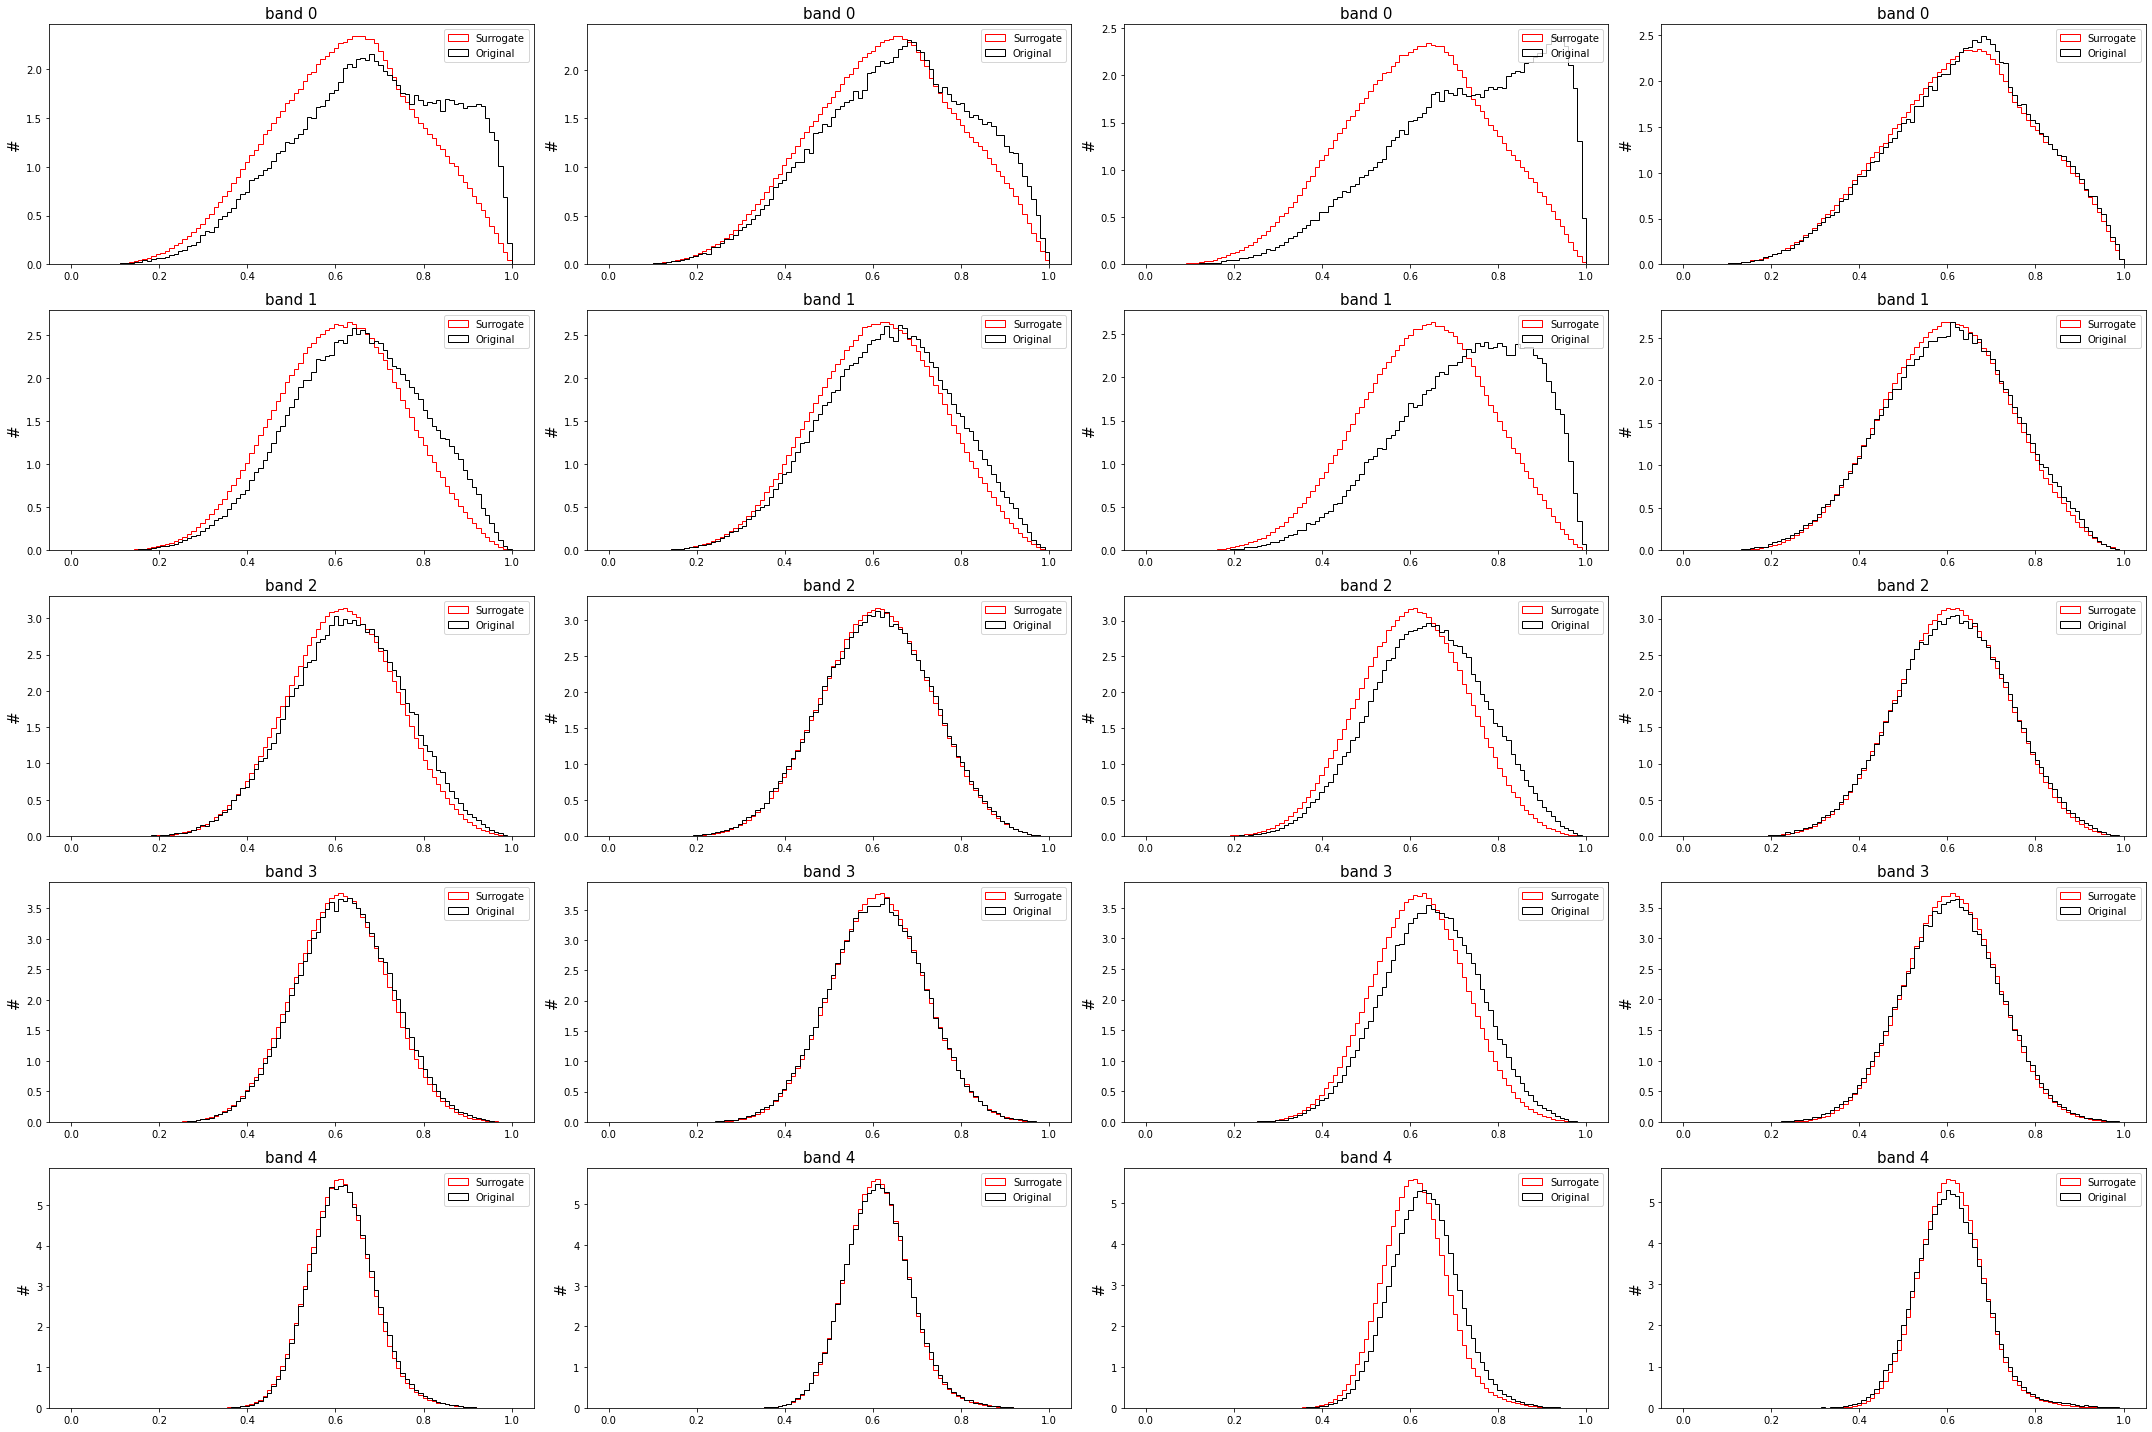

In [77]:
# Saving distributions for trial shuffling surrogates
bins = np.linspace(0,1,100)
count = 1
plt.figure(figsize=(30,20))
for i in range(coh.sizes['freqs']):
    for r in ei:#tqdm( range(coh.sizes['roi']) ):
        plt.subplot(coh.sizes['freqs'],len(ei),count)
        #plt.suptitle(f'link={coh.roi.values[r]}', fontsize=15)
        plt.hist( coh_surr.isel(freqs=i,roi=r).values.flatten(), bins=bins, density=True, histtype='step', fill=False, color='r', label='Surrogate');
        plt.hist( coh.isel(freqs=i, roi=r).values.flatten(), bins=bins,  density=True, histtype='step', fill=False, color='k', label='Original', lw=1);
        plt.title(f'band {i}', fontsize=15)
        plt.ylabel('#', fontsize=15) 
        plt.legend()
        count += 1
plt.tight_layout()

### Comparing with dFC

In [ ]:
from GDa.fc.dFC import conn_correlation

In [10]:
#x_s, x_t  = np.triu_indices(data.sizes['roi'], k=1)
#pairs     = np.array([x_s,x_t]).T

In [11]:
dfc = []
for f_0,f_1 in foi:
    dfc += [dFC(data,times=data.time,sfreq=data.attrs['fsample'], win_args=dict(slwin_len=.5, slwin_step=.02), 
               decim=10,roi=data.roi, f_low=f_0, f_high=f_1, pairs=pairs, n_jobs=-1)];
dfc = xr.concat(dfc,dim="freqs")

Compute pairwise dFC (n_pairs=1176, decim=10)


Setting up band-pass filter from 0.1 - 6 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 6.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    1.8s
[Parallel(n_jobs=40)]: Done 183 tasks      | elapsed:    1.9s
[Parallel(n_jobs=40)]: Done 1536 tasks      | elapsed:    2.3s
[Parallel(n_jobs=40)]: Done 10880 tasks      | elapsed:    4.1s
[Parallel(n_jobs=40)]: Done 23552 tasks      | elapsed:    6.6s
[Parallel(n_jobs=40)]: Done 26004 tasks      | elapsed:    7.5s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:    8.1s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=10)


Setting up band-pass filter from 6 - 14 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 6.00, 14.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    3.9s
[Parallel(n_jobs=40)]: Done 178 tasks      | elapsed:    4.0s
[Parallel(n_jobs=40)]: Done 1536 tasks      | elapsed:    4.6s
[Parallel(n_jobs=40)]: Done 6720 tasks      | elapsed:    5.9s
[Parallel(n_jobs=40)]: Done 13056 tasks      | elapsed:    7.4s
[Parallel(n_jobs=40)]: Done 20544 tasks      | elapsed:    9.1s
[Parallel(n_jobs=40)]: Done 25824 tasks      | elapsed:   10.5s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   11.4s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=10)


Setting up band-pass filter from 14 - 26 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 14.00, 26.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    5.2s
[Parallel(n_jobs=40)]: Done 126 tasks      | elapsed:    5.6s
[Parallel(n_jobs=40)]: Done 808 tasks      | elapsed:    6.0s
[Parallel(n_jobs=40)]: Done 8360 tasks      | elapsed:    7.5s
[Parallel(n_jobs=40)]: Done 21032 tasks      | elapsed:    9.8s
[Parallel(n_jobs=40)]: Done 25964 tasks      | elapsed:   11.1s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   11.6s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=10)


Setting up band-pass filter from 26 - 42 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 26.00, 42.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    5.6s
[Parallel(n_jobs=40)]: Done 171 tasks      | elapsed:    5.7s
[Parallel(n_jobs=40)]: Done 1536 tasks      | elapsed:    6.2s
[Parallel(n_jobs=40)]: Done 10880 tasks      | elapsed:    8.0s
[Parallel(n_jobs=40)]: Done 23552 tasks      | elapsed:   10.5s
[Parallel(n_jobs=40)]: Done 26004 tasks      | elapsed:   11.4s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   12.0s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=10)


Setting up band-pass filter from 42 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 42.00, 80.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    6.6s
[Parallel(n_jobs=40)]: Done 177 tasks      | elapsed:    6.7s
[Parallel(n_jobs=40)]: Done 1536 tasks      | elapsed:    7.2s
[Parallel(n_jobs=40)]: Done 16640 tasks      | elapsed:   10.5s
[Parallel(n_jobs=40)]: Done 25856 tasks      | elapsed:   12.2s
[Parallel(n_jobs=40)]: Done 26324 tasks      | elapsed:   12.9s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   13.0s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

In [12]:
dfc_surr = []
for f_0,f_1 in foi:
    dfc_surr += [dFC(data_surr.isel(seeds=0),times=data.time,sfreq=data.attrs['fsample'], win_args=dict(slwin_len=.5, slwin_step=.02), 
               decim=10,roi=data.roi, f_low=f_0, f_high=f_1, pairs=pairs, n_jobs=-1)];
dfc_surr = xr.concat(dfc_surr,dim="freqs")

Compute pairwise dFC (n_pairs=1176, decim=10)


Setting up band-pass filter from 0.1 - 6 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 6.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    3.3s
[Parallel(n_jobs=40)]: Done 128 tasks      | elapsed:    3.5s
[Parallel(n_jobs=40)]: Done 808 tasks      | elapsed:    3.8s
[Parallel(n_jobs=40)]: Done 11560 tasks      | elapsed:    5.6s
[Parallel(n_jobs=40)]: Done 25816 tasks      | elapsed:    8.4s
[Parallel(n_jobs=40)]: Done 26284 tasks      | elapsed:    9.1s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:    9.3s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=10)


Setting up band-pass filter from 6 - 14 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 6.00, 14.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    4.3s
[Parallel(n_jobs=40)]: Done 173 tasks      | elapsed:    4.4s
[Parallel(n_jobs=40)]: Done 1536 tasks      | elapsed:    5.0s
[Parallel(n_jobs=40)]: Done 6720 tasks      | elapsed:    6.1s
[Parallel(n_jobs=40)]: Done 13056 tasks      | elapsed:    7.6s
[Parallel(n_jobs=40)]: Done 20544 tasks      | elapsed:    9.5s
[Parallel(n_jobs=40)]: Done 25824 tasks      | elapsed:   11.3s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   12.2s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=10)


Setting up band-pass filter from 14 - 26 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 14.00, 26.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    5.0s
[Parallel(n_jobs=40)]: Done 174 tasks      | elapsed:    5.1s
[Parallel(n_jobs=40)]: Done 1536 tasks      | elapsed:    5.7s
[Parallel(n_jobs=40)]: Done 6720 tasks      | elapsed:    6.9s
[Parallel(n_jobs=40)]: Done 13056 tasks      | elapsed:    8.4s
[Parallel(n_jobs=40)]: Done 20544 tasks      | elapsed:   10.4s
[Parallel(n_jobs=40)]: Done 25824 tasks      | elapsed:   11.9s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   12.8s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=10)


Setting up band-pass filter from 26 - 42 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 26.00, 42.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    6.0s
[Parallel(n_jobs=40)]: Done 171 tasks      | elapsed:    6.1s
[Parallel(n_jobs=40)]: Done 1536 tasks      | elapsed:    6.7s
[Parallel(n_jobs=40)]: Done 6720 tasks      | elapsed:    7.9s
[Parallel(n_jobs=40)]: Done 13056 tasks      | elapsed:    9.5s
[Parallel(n_jobs=40)]: Done 20544 tasks      | elapsed:   11.1s
[Parallel(n_jobs=40)]: Done 25824 tasks      | elapsed:   12.5s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   13.4s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=10)


Setting up band-pass filter from 42 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 42.00, 80.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    6.9s
[Parallel(n_jobs=40)]: Done 171 tasks      | elapsed:    7.0s
[Parallel(n_jobs=40)]: Done 1536 tasks      | elapsed:    7.6s
[Parallel(n_jobs=40)]: Done 9600 tasks      | elapsed:    9.4s
[Parallel(n_jobs=40)]: Done 22272 tasks      | elapsed:   12.0s
[Parallel(n_jobs=40)]: Done 25330 tasks      | elapsed:   13.0s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   13.7s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

In [ ]:
bins = np.linspace(-5,5,100)
for r in tqdm( range(coh.sizes['roi']) ):
    plt.figure(figsize=(8,15))
    count = 1
    for i in range(5):
        plt.subplot(5,1,count)
        plt.suptitle(f'link={coh.roi.values[r]}', fontsize=15)
        plt.hist( dfc_surr.isel(freqs=i,roi=r).values.flatten(), bins=bins, density=True, histtype='step', fill=False, color='r', label='Surrogate');
        plt.hist( dfc.isel(freqs=i, roi=r).values.flatten(), bins=bins,  density=True, histtype='step', fill=False, color='k', label='Original');
        plt.title(f'band {i}', fontsize=15)
        plt.ylabel('#', fontsize=15) 
        plt.legend()
        count += 1
    plt.tight_layout()
    plt.xlabel(f'Coherence', fontsize=15)
    plt.savefig(f'img/surr_dfc/surr_dist_roi{r}_dfc.png')
    plt.close()

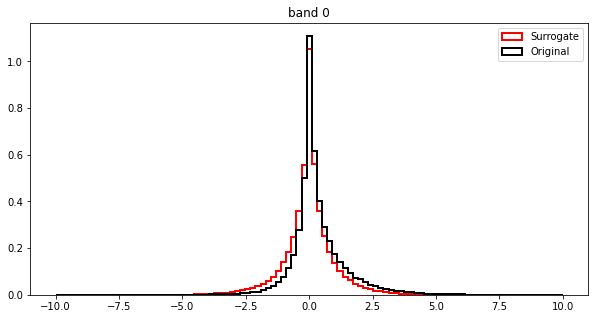

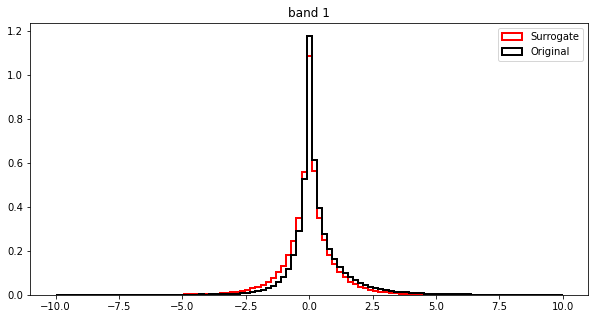

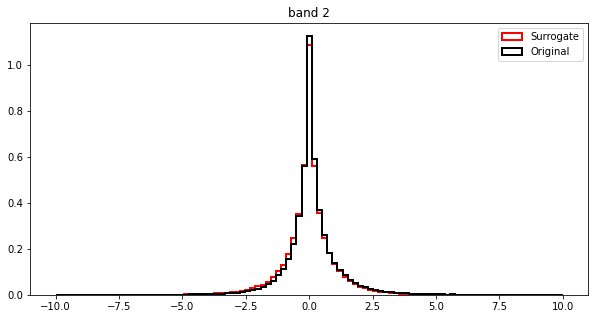

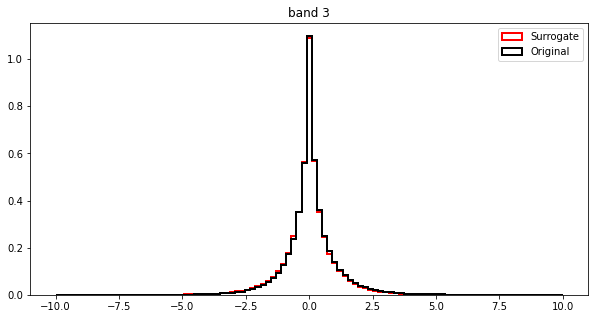

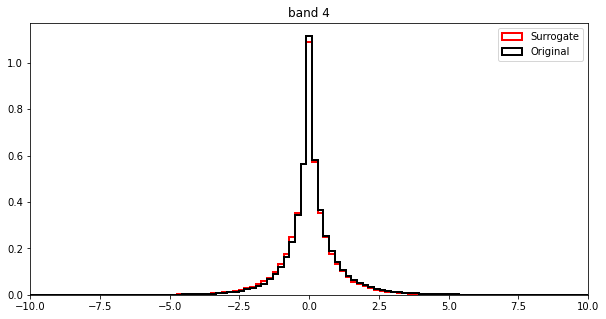

In [21]:
bins = np.linspace(-10,10,100)
for i in range(5):
    plt.figure(figsize=(10,5))
    plt.hist( dfc_surr.isel(freqs=i, roi=0).values.flatten(), bins=bins,  color='red', label='Surrogate', density=True, histtype='step', fill=False, lw=2)
    plt.hist( dfc.isel(freqs=i, roi=0).values.flatten(), bins=bins,  color='k', label='Original', density=True, histtype='step', fill=False, lw=2)
    plt.title(f'band {i}')
    plt.legend()
plt.xlim(-10,10);

In [24]:
ks_stats   = np.zeros((dfc.sizes['roi'],dfc.sizes['freqs']))
ks         = ks_test(dfc.values,dfc_surr.values[None,:,:,:,:],True,-1)

  0%|          |  : 0/5 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


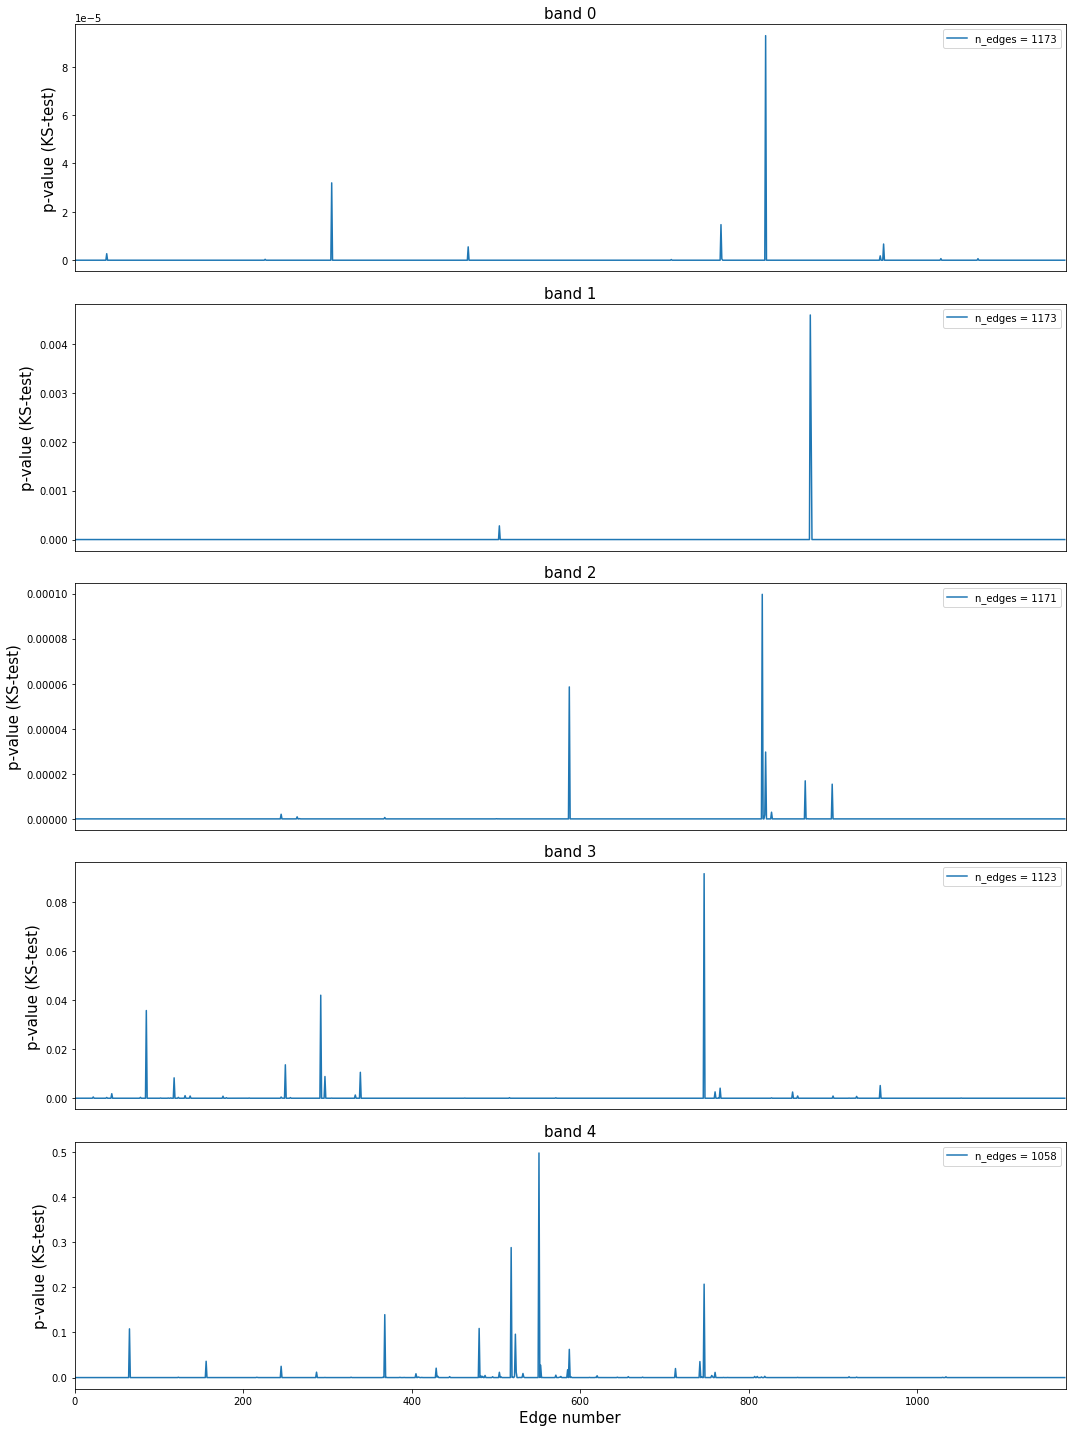

In [25]:
plt.figure(figsize=(15,20))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.plot(ks[i], label=f'n_edges = {np.sum(ks[i]<1e-5)}')
    plt.ylabel('p-value (KS-test)', fontsize=15)
    if i == 4: plt.xlabel('Edge number', fontsize=15)
    else: plt.xticks([])
    plt.title(f'band {i}', fontsize=15)
    plt.xlim([0,ks[i].shape[0]])
    plt.legend()
plt.tight_layout()
plt.savefig('img/ks_test_dfc.png', dpi=200)

In [26]:
ks_mat = np.zeros((5,data.sizes['roi'],data.sizes['roi']))
for i in range(5):
    idx         = ks[i] <1e-5
    x_s_i,x_t_i = x_s[idx], x_t[idx]
    ks_mat[i,x_s_i,x_t_i] = ks_mat[i,x_t_i,x_s_i] = 1

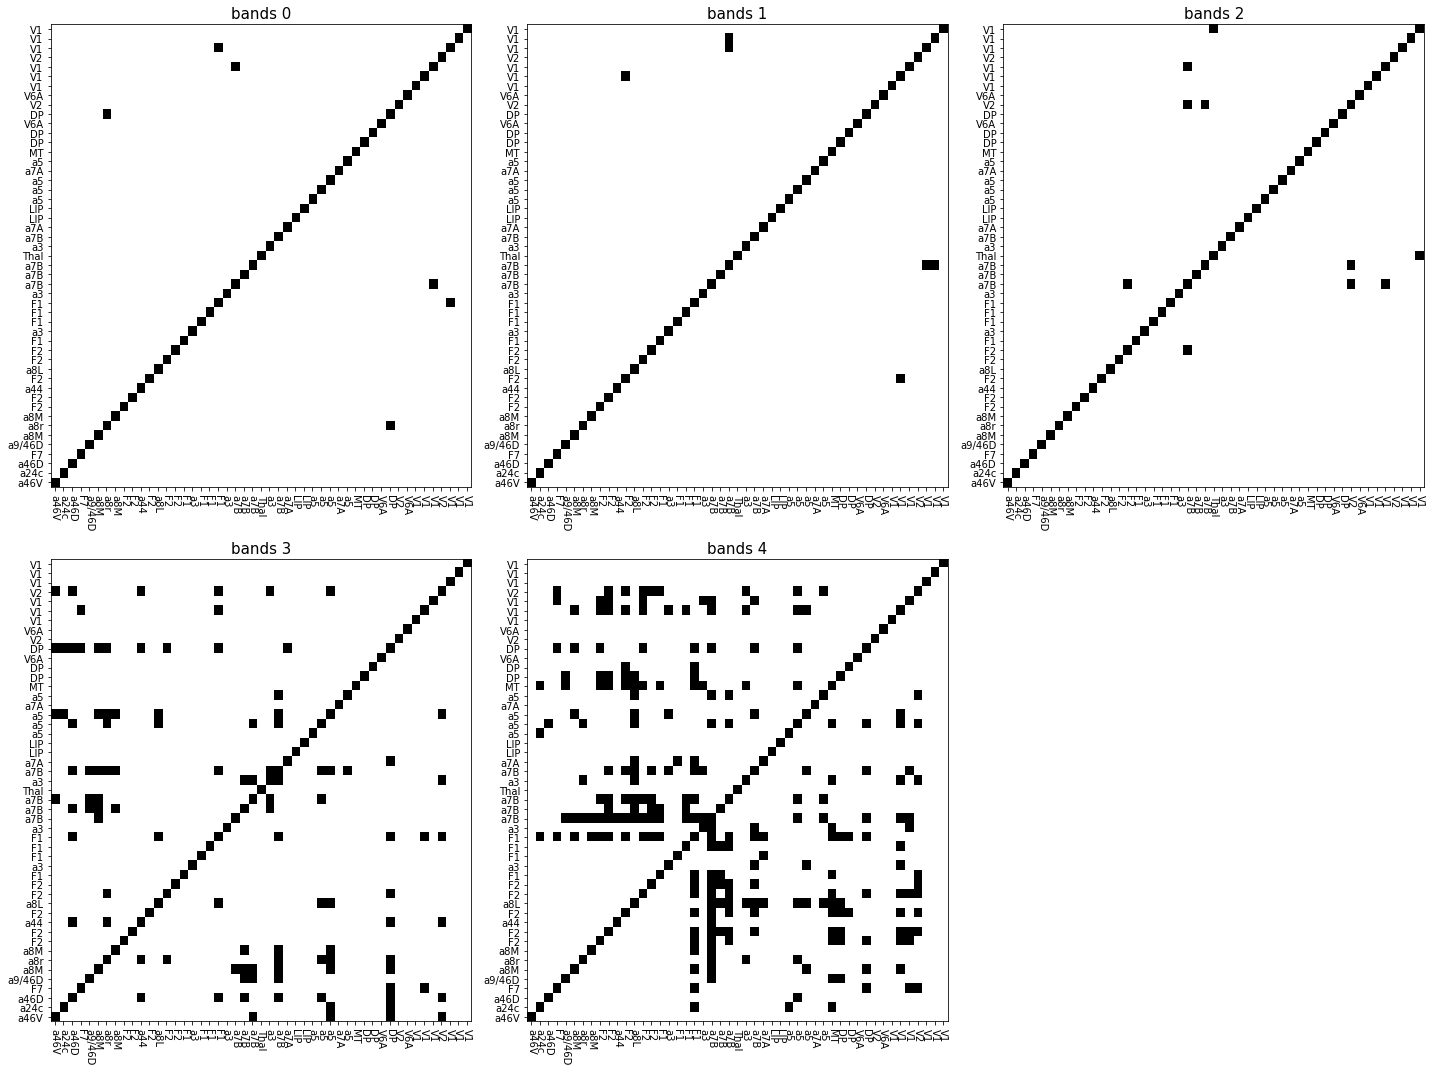

In [27]:
plt.figure(figsize=(20,15))
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.imshow(ks_mat[i], aspect='auto', origin = 'lower', cmap='gray')
    plt.xticks(range(data.sizes['roi']), data.roi.values, rotation=270)
    plt.yticks(range(data.sizes['roi']), data.roi.values)
    plt.title(f'bands {i}', fontsize=15)
plt.tight_layout()

In [28]:
# Edges with signigicative coherence for all bands
idx = (ks[0]<1e-5)*(ks[1]<1e-5)*(ks[2]<1e-5)*(ks[3]<1e-5)*(ks[4]<1e-5)

In [29]:
# Sample four edge indexes
ei  = np.sort( np.random.choice( np.where(idx==True)[0], 4) )

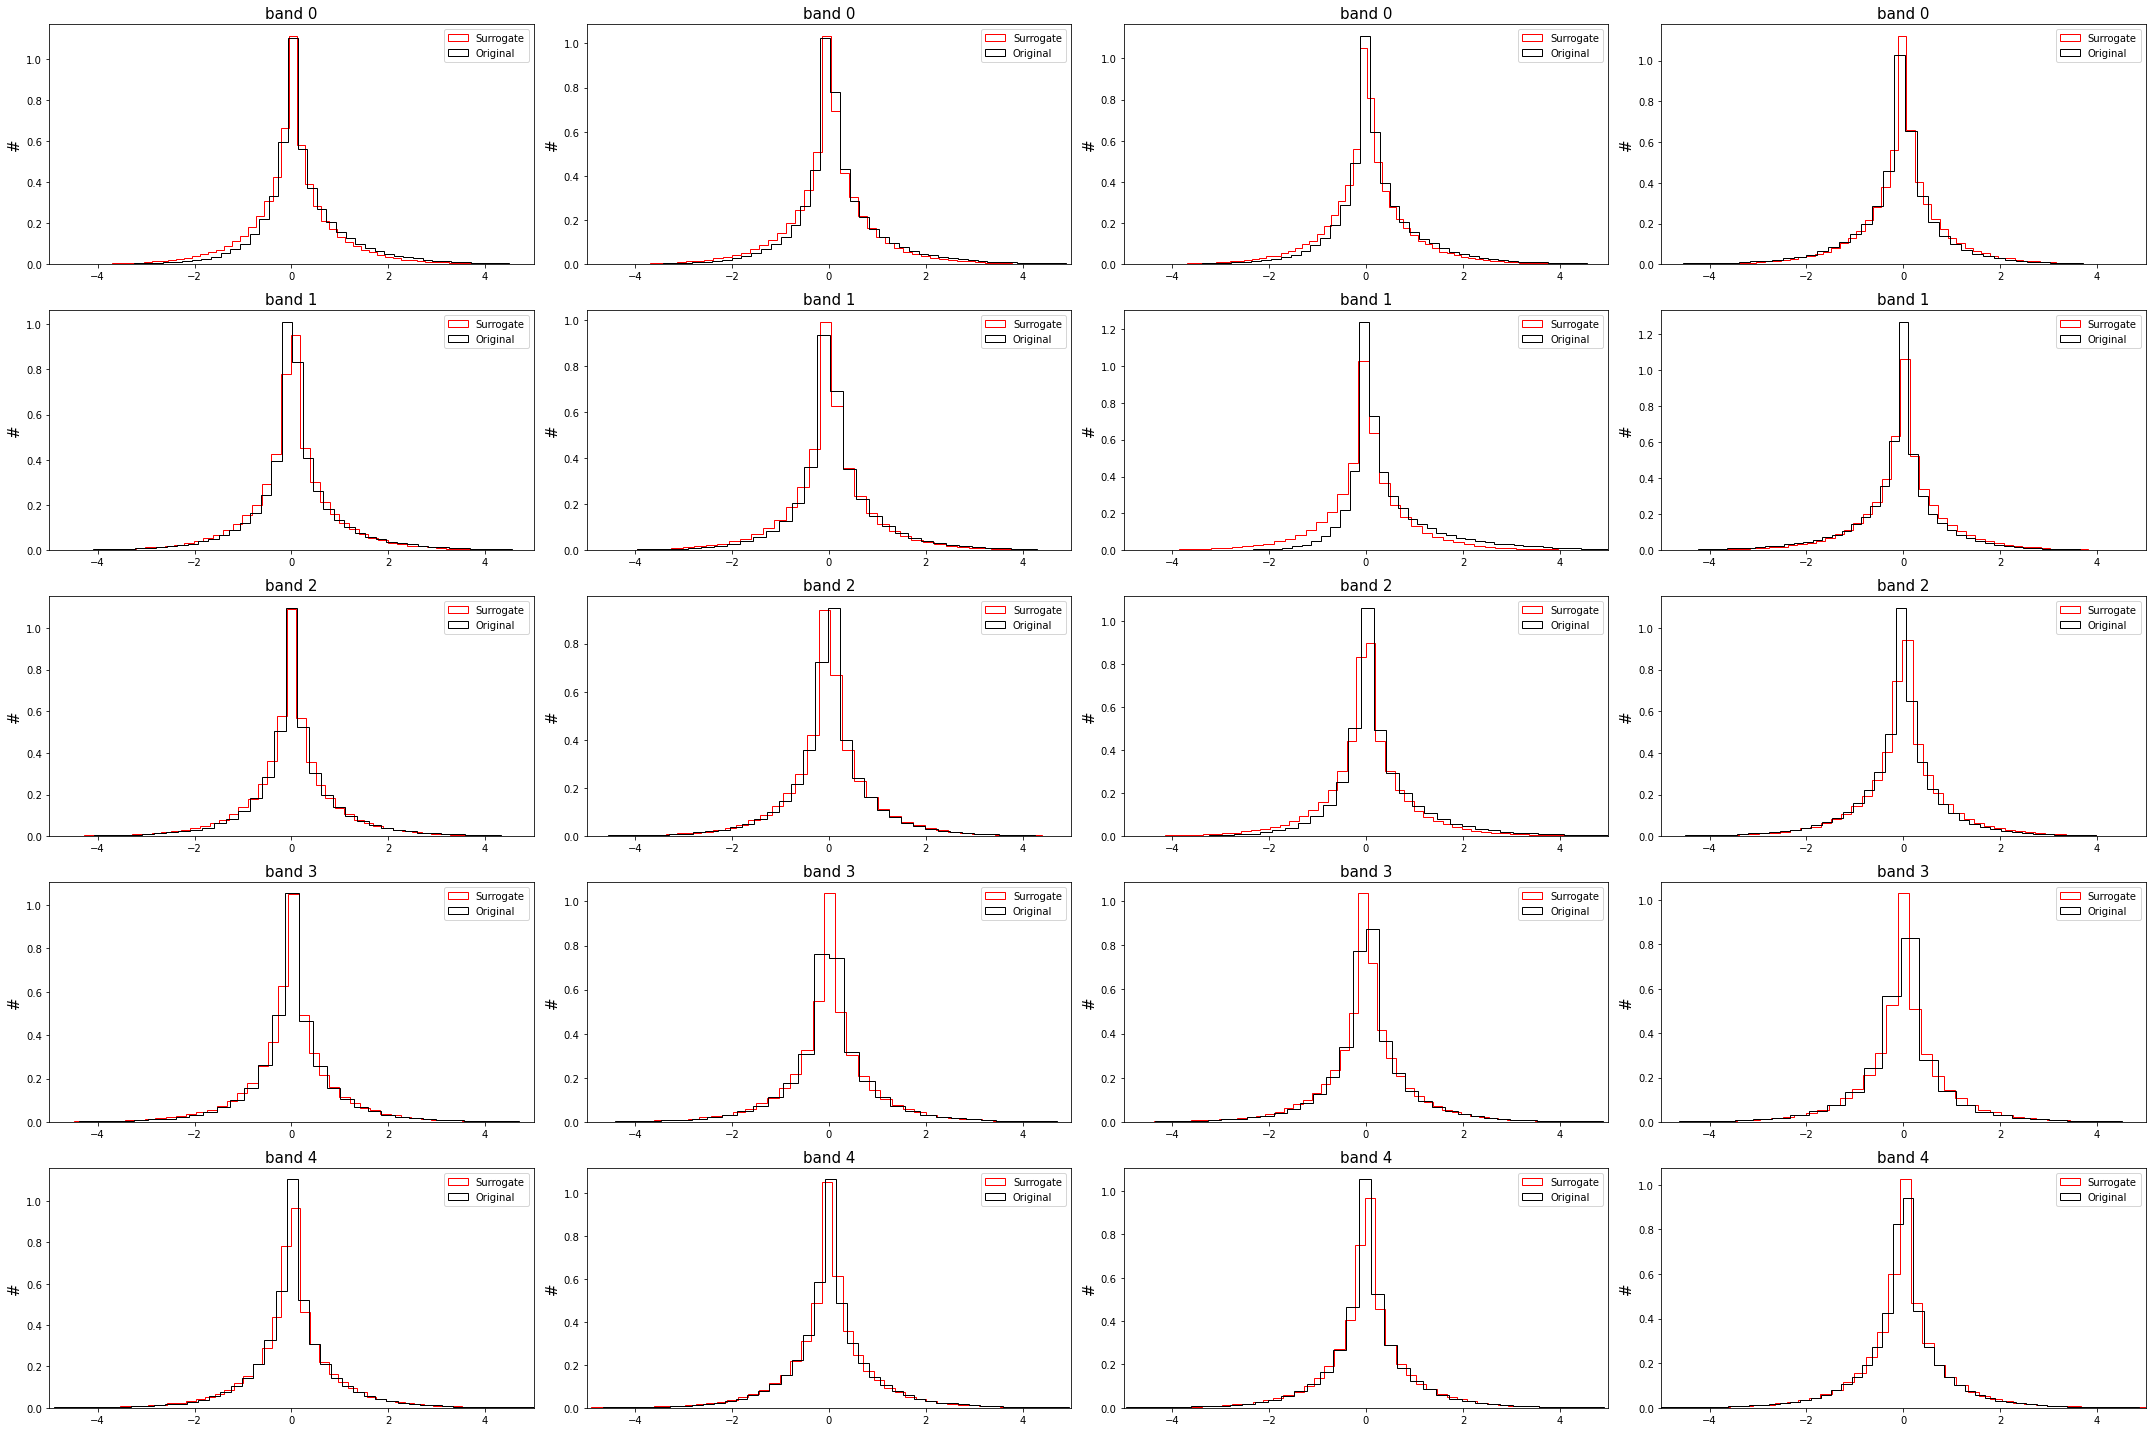

In [41]:
# Saving distributions for trial shuffling surrogates
bins = 100#np.linspace(-2, 2, 100)
count = 1
plt.figure(figsize=(30,20))
for i in range(dfc.sizes['freqs']):
    for r in ei:#tqdm( range(coh.sizes['roi']) ):
        plt.subplot(dfc.sizes['freqs'],len(ei),count)
        #plt.suptitle(f'link={coh.roi.values[r]}', fontsize=15)
        plt.hist( dfc_surr.isel(freqs=i,roi=r).values.flatten(), bins=bins, density=True, histtype='step', fill=False, color='r', label='Surrogate');
        plt.hist( dfc.isel(freqs=i, roi=r).values.flatten(), bins=bins,  density=True, histtype='step', fill=False, color='k', label='Original', lw=1);
        plt.title(f'band {i}', fontsize=15)
        plt.ylabel('#', fontsize=15)
        plt.xlim([-5,5])
        plt.legend()
        count += 1
plt.tight_layout()

#### Meta-Connectivity (Original vs. Surrogate)

In [ ]:
from   GDa.temporal_network import temporal_network

In [ ]:
#### Instantiate a temporal network object without thresholding the data
net =  temporal_network(data_raw_path='../GrayLab/', 
                        tensor_raw_path='../Results/lucy/150128/session01/super_tensor.nc', monkey='lucy', 
                        session=1, date='150128', trial_type=[1],
                        behavioral_response=[1], wt=(20,20), drop_trials_after=True,
                        relative=True, verbose=True, q=None, keep_weights=False)

In [ ]:
coh = coh[...,20:-20]

In [ ]:
coh = coh.transpose('roi', 'freqs', 'trials', 'times')

In [ ]:
coh_surr = xr.load_dataarray('data/coh_surr_rt.nc')

In [ ]:
coh_surr = coh_surr[...,20:-20]

In [ ]:
MC = conn_correlation(coh.isel(freqs=0, trials=[0]).values, times=coh.times, roi=None, sfreq=None, f_low=None, f_high=None, pairs=None, decim=None, 
     block_size=None, verbose=False, n_jobs=-1)